#### Import modules

In [31]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series

#### Load data

In [32]:
data_path = os.path.abspath(os.path.join('..','..', 'data_copy/forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

all_data = load_data(data_path)
file_tag = "ARREST"
target = "Manhattan"



data = all_data[[target]]


In [33]:
from pandas import DataFrame

def dataframe_train_test_split(data: DataFrame, trn_pct: float = 0.90) -> tuple[DataFrame, DataFrame]:
    trn_size = int(len(data) * trn_pct)
    train = data.iloc[:trn_size]
    test = data.iloc[trn_size:]
    return train, test


#### Preparation

In [34]:
import pandas as pd

def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False) 
    # Train/test split
    train, test = dataframe_train_test_split(data)   
    
    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(train)
    train_scaled = DataFrame(transf.transform(train), index=train.index, columns=train.columns)
    test_scaled = DataFrame(transf.transform(test), index=test.index, columns=test.columns) 

    # Smoothing
    WIN_SIZE = 10
    train_smooth: Series = train_scaled.rolling(window=WIN_SIZE).mean()
    train_smooth = train_smooth.dropna()

    # Differentiation
    train_diff: Series = train_smooth.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test_scaled.diff()
    test_diff = test_diff.dropna()

    return train_diff, test_diff
    
    
train, test = data_preparation(data)

train_all, test_all = data_preparation(all_data)


print(train.columns, test.columns)
print(train_all.columns, test_all.columns)

Index(['Manhattan'], dtype='object') Index(['Manhattan'], dtype='object')
Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object') Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object')


### Evaluation

#### Training

In [35]:
from pandas import Series


def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, :]
    test: Series = df_cp.iloc[trn_size:]
    return train, test

In [36]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots, savefig
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_PAST_COLOR, PRED_FUTURE_COLOR, HEIGHT


def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

In [37]:
from math import sqrt
from dslabs_functions import plot_multibar_chart, FORECAST_MEASURES


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)
    return axs

#### Simple average 

In [38]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

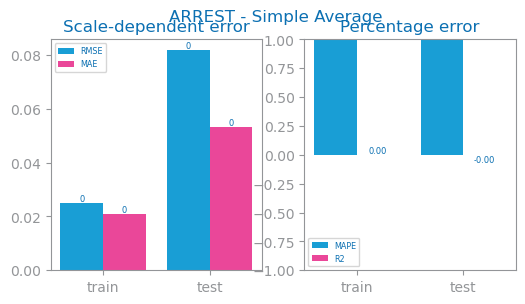

In [39]:
from pandas import read_csv, DataFrame, Series

timecol: str = "Date"


fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Simple Average")
savefig(f"images/{file_tag}_simpleAvg_eval.png")

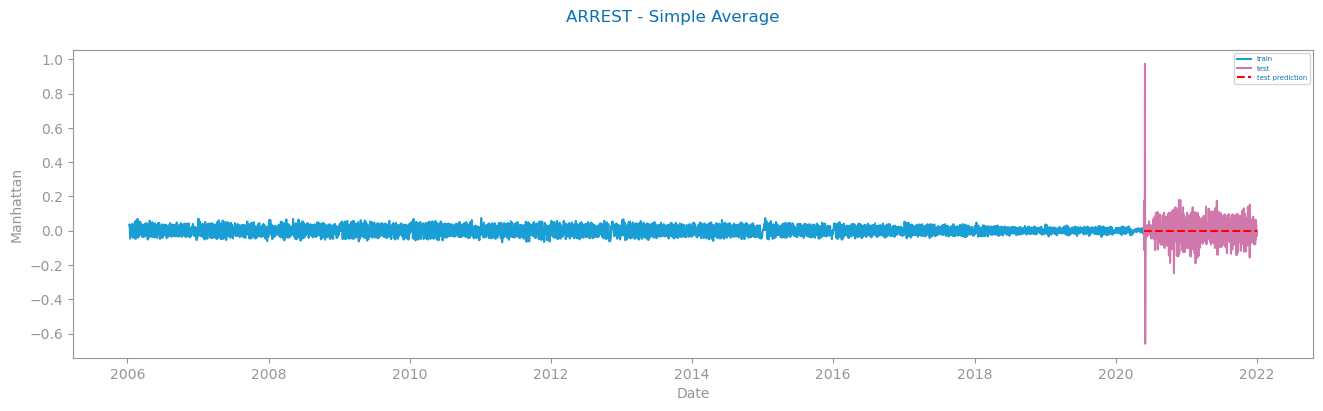

In [40]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Simple Average",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_simpleAvg_forecast.png")

#### Persistence Model

In [41]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

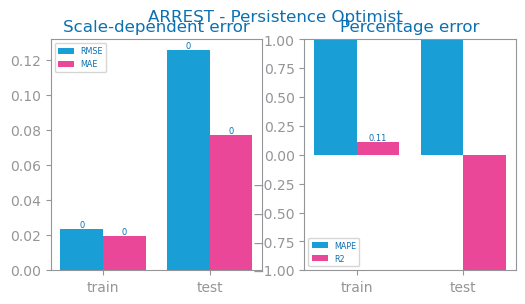

In [42]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series


fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist")
savefig(f"images/{file_tag}_persistence_optim_eval.png")

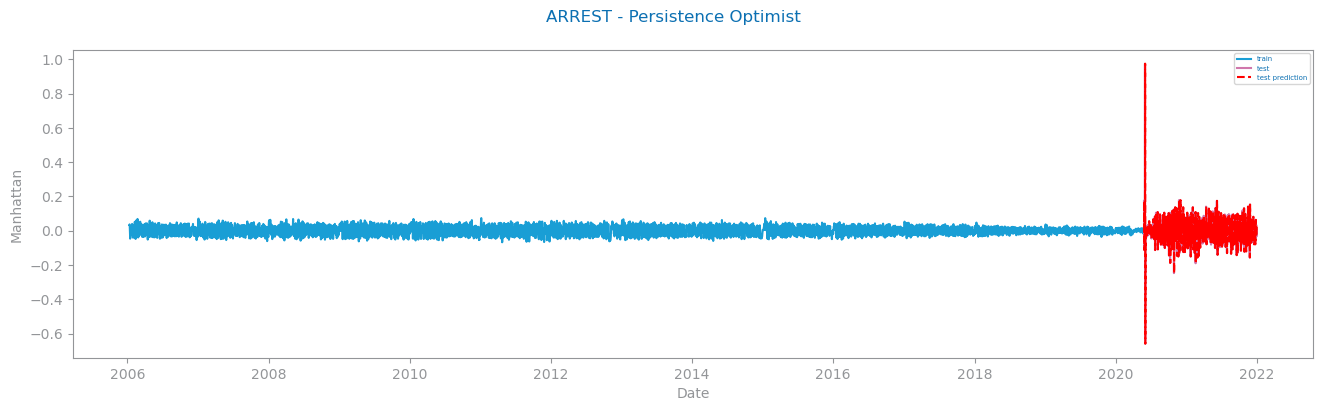

In [43]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_optim_forecast.png")

In [44]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

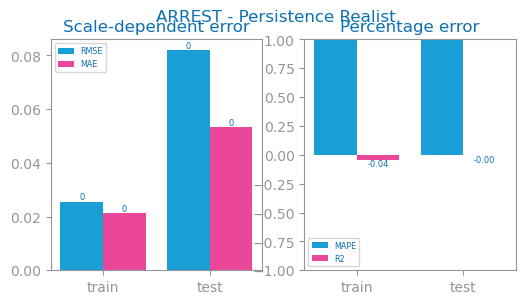

In [45]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist")
savefig(f"images/{file_tag}_persistence_real_eval.png")

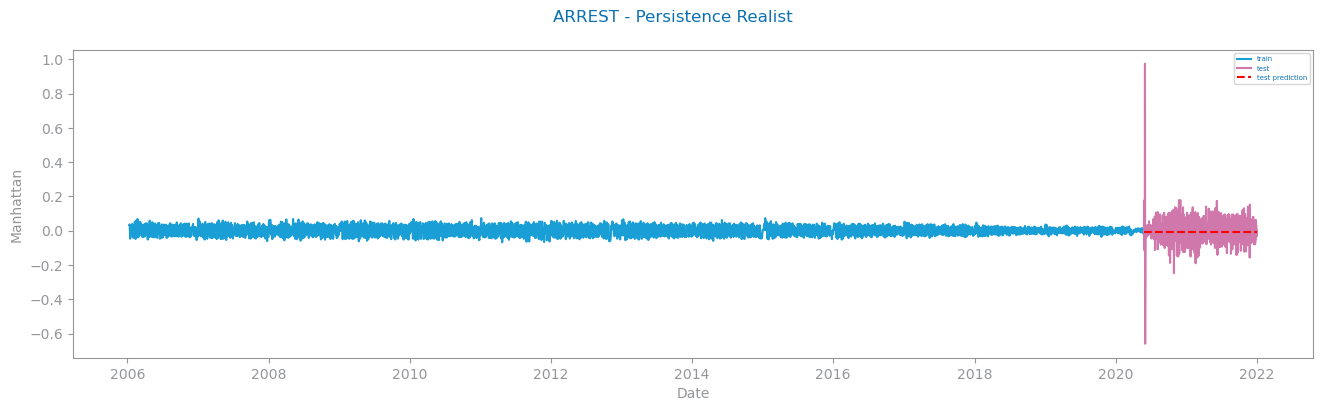

In [46]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_real_forecast.png")

#### Exponential Smoothing

In [47]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import series_train_test_split, HEIGHT

In [48]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

Exponential Smoothing best with alpha=0 -> R2=-3.872632246437746e-06


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-p

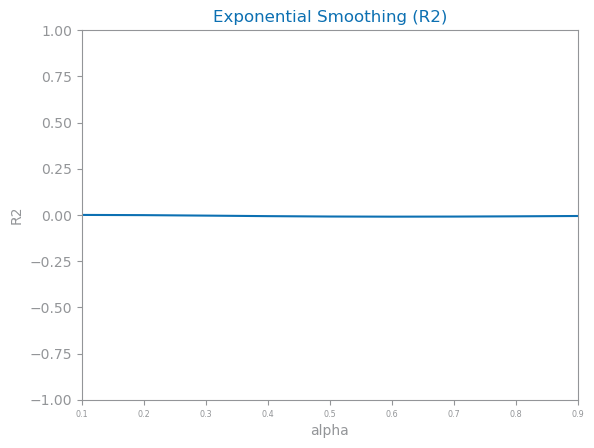

In [49]:
measure: str = "R2"
from matplotlib.pyplot import savefig

best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_study.png")

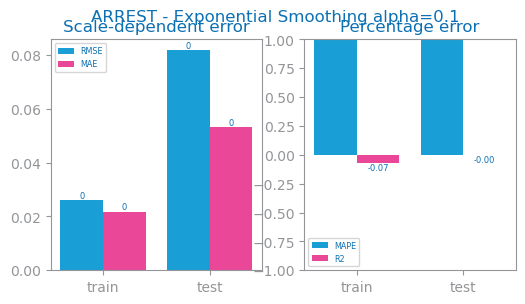

In [50]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")

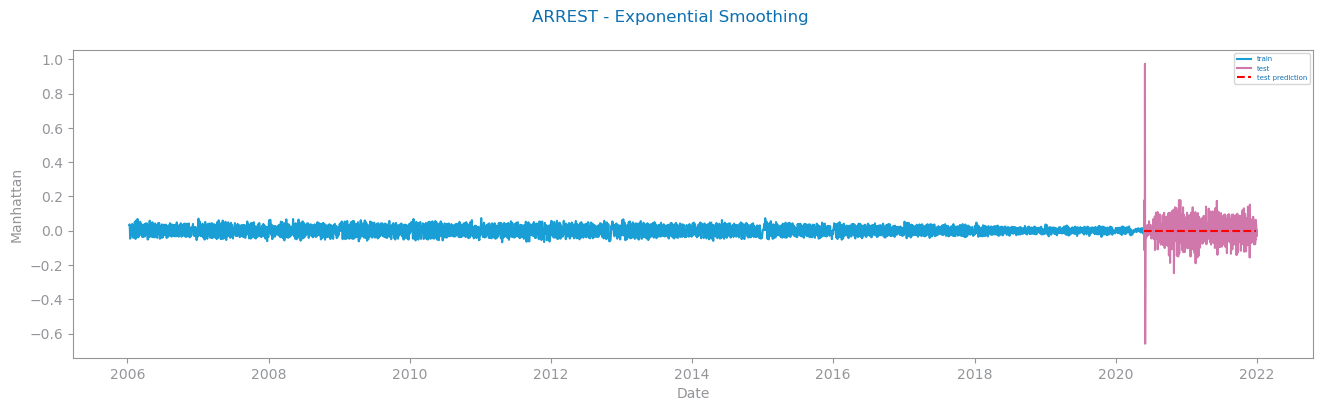

In [51]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_forecast.png")

### Rolling Mean

In [52]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin


class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

In [53]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

Rolling Mean best with win=12 -> R2=-1.073853308941608e-05


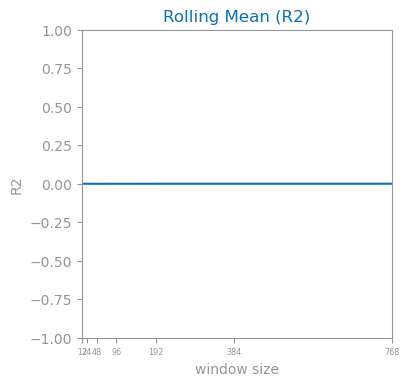

In [54]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series, HEIGHT


train_series = train.iloc[:, 0]
test_series = test.iloc[:, 0]

fig = figure(figsize=(HEIGHT, HEIGHT))
best_model, best_params = rolling_mean_study(train_series, test_series)
savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

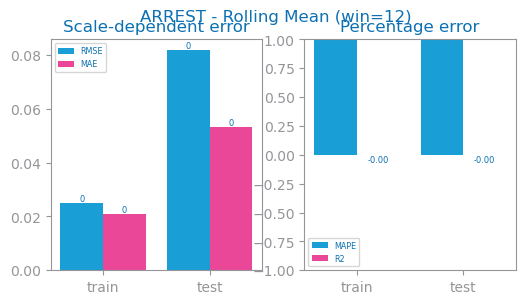

In [55]:
params = best_params["params"]
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"images/{file_tag}_rollingmean_{measure}_win{params[0]}_eval.png")

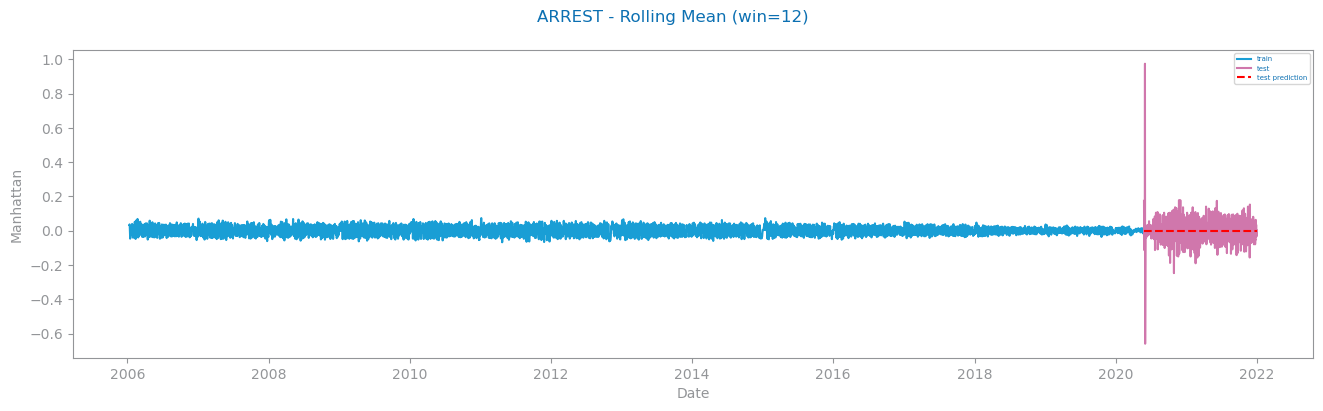

In [56]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_rollingmean_{measure}_forecast.png")

#### Lineair Regression

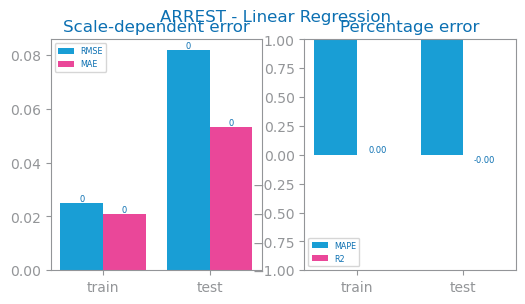

In [57]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, plot_forecasting_eval


trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(train) + len(test)).reshape(-1, 1)

tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn = Series(model.predict(trnX).flatten(), index=train.index)
prd_tst = Series(model.predict(tstX).flatten(), index=test.index)



plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

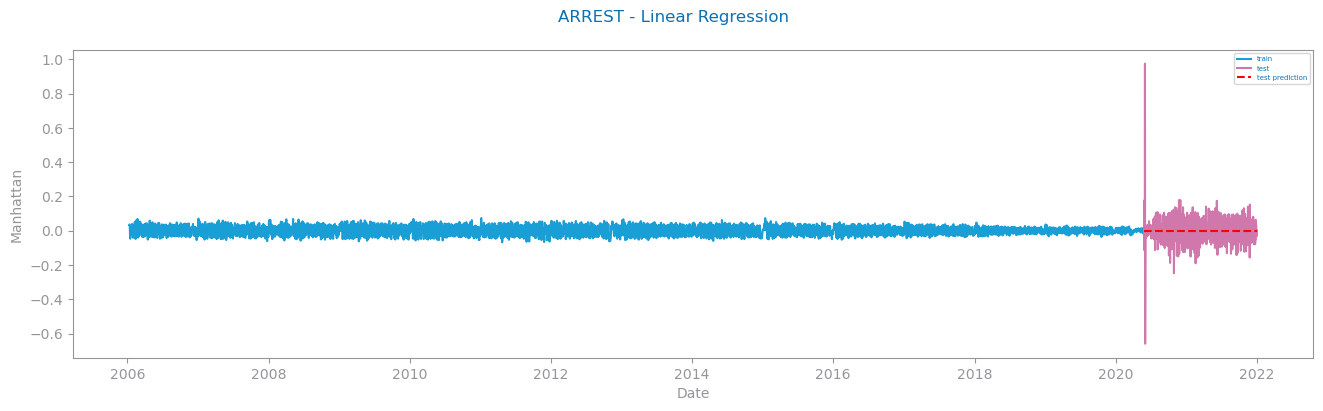

In [58]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")

#### ARIMA

In [59]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT


predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Manhattan   No. Observations:                 5249
Model:                 ARIMA(3, 1, 2)   Log Likelihood               14427.165
Date:                Fri, 10 Jan 2025   AIC                         -28842.329
Time:                        13:28:15   BIC                         -28802.936
Sample:                    01-11-2006   HQIC                        -28828.556
                         - 05-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7566      0.037     20.495      0.000       0.684       0.829
ar.L2         -0.3133      0.032     -9.747      0.000      -0.376      -0.250
ar.L3         -0.2609      0.022    -12.131      0.0

/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


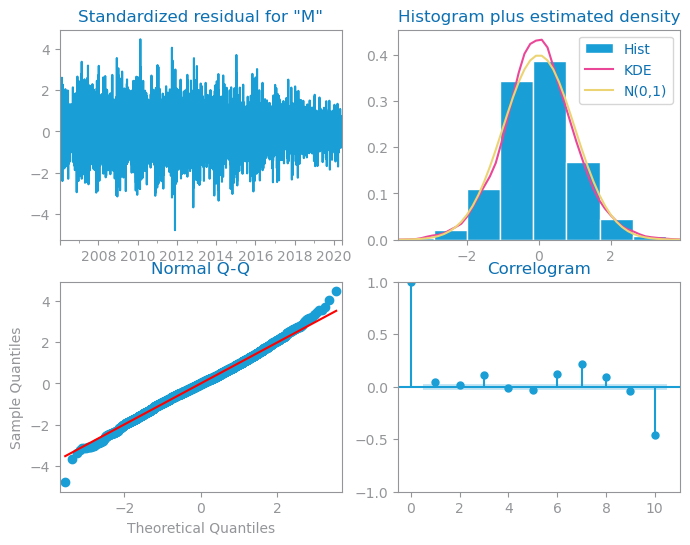

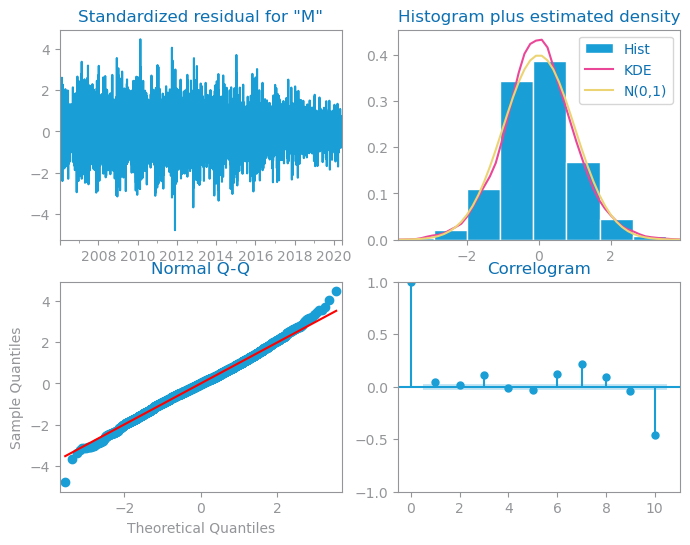

In [60]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [61]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-p

ARIMA best results achieved with (p,d,q)=(10, 0, 5) ==> measure=0.00


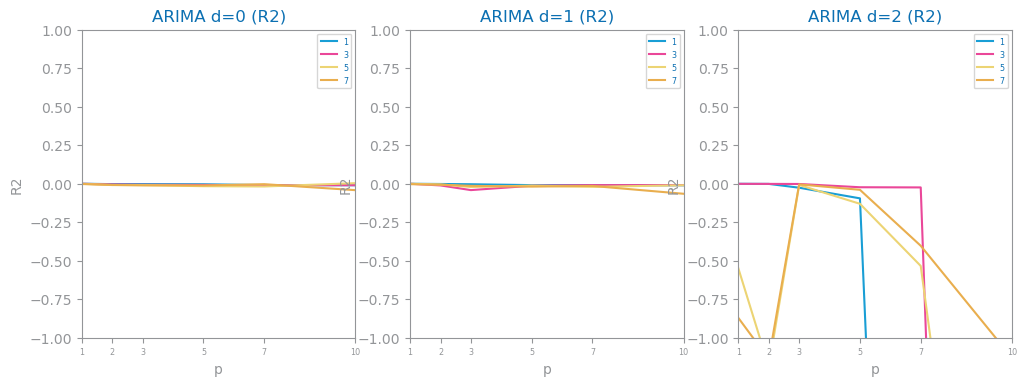

In [62]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

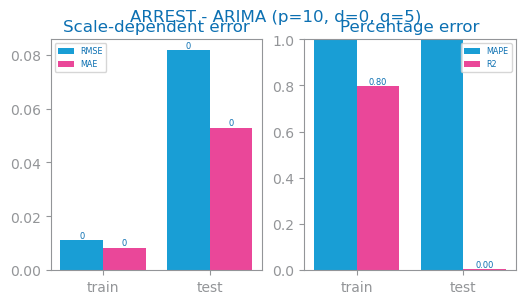

In [63]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

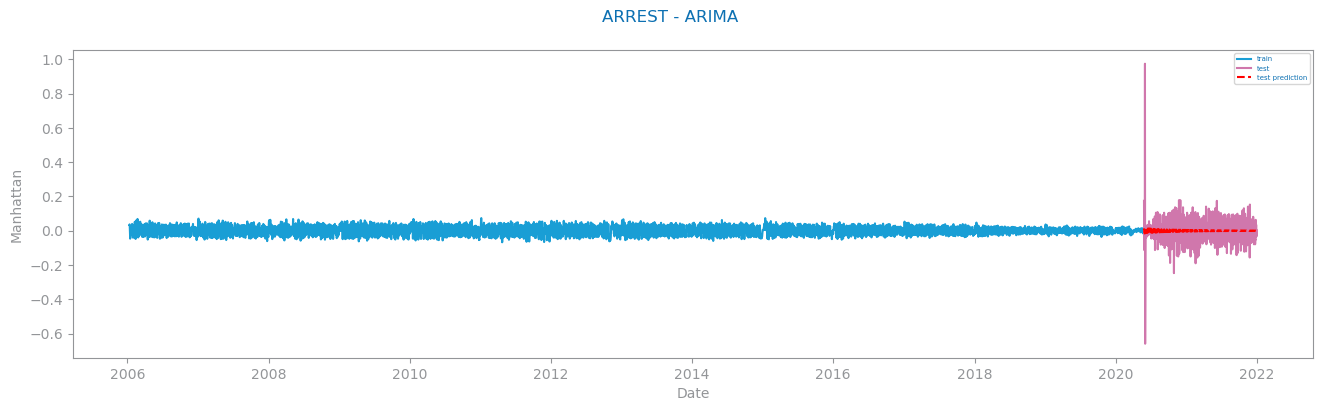

In [64]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_arima_{measure}_forecast.png")

#### multi Arima

In [65]:
from dslabs_functions import plot_ts_multivariate_chart

In [66]:
print(train_all.columns)  # Check the column names in the train DataFrame
print(test_all.columns)   # Check the column names in the test DataFrame


Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object')
Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object')


In [67]:
# Target
train_y = train_all["Manhattan"]
test_y = test_all["Manhattan"]

# Exogenous features (as many as you have)
train_X = train_all[['Brooklyn', 'Queens', 'StatenIsland', 'Bronx']]
test_X = test_all[['Brooklyn', 'Queens', 'StatenIsland', 'Bronx']]


In [68]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# For instance, let's do an ARIMA(3,1,2) with exogenous:
model = SARIMAX(train_y, exog=train_X, order=(3,1,2))
results = model.fit()
print(results.summary())

# Forecast
# We pass exogenous test data to forecast the same number of steps as test_y:
pred_test = results.forecast(steps=len(test_y), exog=test_X)

# Evaluate the predictions in your usual manner
# print("RMSE =", FORECAST_MEASURES["RMSE"](test_y, pred_test))
print("R2 =", FORECAST_MEASURES["R2"](test_y, pred_test))


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57330D+00    |proj g|=  1.52620D+02

At iterate    5    f= -2.83611D+00    |proj g|=  5.22727D-01

At iterate   10    f= -2.87360D+00    |proj g|=  1.44017D+01

At iterate   15    f= -2.90838D+00    |proj g|=  4.80358D+00

At iterate   20    f= -3.16212D+00    |proj g|=  5.99010D+00

At iterate   25    f= -3.16529D+00    |proj g|=  1.22974D+00

At iterate   30    f= -3.18459D+00    |proj g|=  7.52465D+00

At iterate   35    f= -3.26389D+00    |proj g|=  3.72518D+00

At iterate   40    f= -3.26653D+00    |proj g|=  2.73806D+00

At iterate   45    f= -3.27529D+00    |proj g|=  3.95820D+00


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.27610D+00    |proj g|=  4.23101D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   4.231D-01  -3.276D+00
  F =  -3.2760998708410729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:              Manhattan   No. Observations:                 5249
Model:               SARIMAX(3, 1, 2)   Log Likelihood               17196.248
Date:                Fri, 10 Jan 2025   AIC                         -34372.496
Time:                        13:33:33   BIC  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20036D+00    |proj g|=  7.18352D+00


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.20236D+00    |proj g|=  3.42440D+00

At iterate   10    f= -3.21079D+00    |proj g|=  5.25854D-01

At iterate   15    f= -3.21305D+00    |proj g|=  4.30106D+00

At iterate   20    f= -3.22937D+00    |proj g|=  8.39011D-02

At iterate   25    f= -3.22962D+00    |proj g|=  1.25510D+00

At iterate   30    f= -3.24208D+00    |proj g|=  6.05681D+00

At iterate   35    f= -3.25237D+00    |proj g|=  1.95208D-01

At iterate   40    f= -3.25266D+00    |proj g|=  1.43470D+00

At iterate   45    f= -3.26617D+00    |proj g|=  1.05364D+01


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.28068D+00    |proj g|=  2.97431D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.974D-01  -3.281D+00
  F =  -3.2806806160591866     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:              Manhattan   No. Observations:                 5249
Model:               SARIMAX(1, 1, 1)   Log Likelihood               17220.293
Date:                Fri, 10 Jan 2025   AIC                         -34426.585
Time:                        13:33:37   BIC  

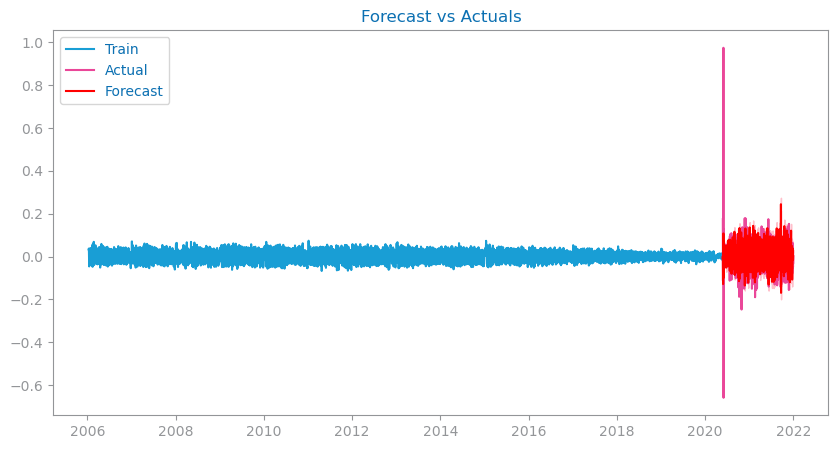

In [69]:
# Build the SARIMAX Model
model = SARIMAX(train_y, exog=train_X, order=(1,1,1))
results = model.fit()

# Print model summary
print(results.summary())

# Forecast
forecast = results.get_forecast(steps=len(test_y), exog=test_X)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_y, forecast_values))
print(f'RMSE: {rmse}')

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='r')
plt.fill_between(forecast_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()
